In [1]:
import numpy as np
from scipy import misc
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
def padding(input_matrix, no_of_layers):
    
    #depth = input_matrix.shape[0]
    height = len(input_matrix)
    width = len(input_matrix[0])
#     print "layers = ", no_of_layers

#     print input_matrix
    
    pad_up = np.zeros((no_of_layers, int(width)))

    input_matrix = np.vstack((pad_up, input_matrix))
    

    temp_height = len(input_matrix)
    
    pad_right = np.zeros((temp_height, no_of_layers))
    input_matrix = np.hstack((input_matrix, pad_right))

    
    temp_width = len(input_matrix[0])
    pad_bottom = np.zeros((no_of_layers, temp_width))
    input_matrix = np.vstack((input_matrix, pad_bottom))

    
    temp_height = len(input_matrix)
    pad_left = np.zeros((temp_height, no_of_layers))
    input_matrix = np.hstack((pad_left, input_matrix))

    
    if(height%2 != 0):
        temp_width = len(input_matrix[0])
        pad_top = np.zeros((1,temp_width))
        input_matrix = np.vstack((pad_top, input_matrix))
        
    
    if(width%2 != 0):
        temp_height = len(input_matrix)
        pad_right = np.zeros((temp_height,1))
        input_matrix = np.hstack((input_matrix, pad_right))
        

    return input_matrix
    
    

In [68]:
def Convolutional_function( image, kernel, stride, pad, activation_function):
#     print "function working"
    
    depth = image.shape[0]
    height = image.shape[1]
    width = image.shape[2]
    
    if(height%2 ==0 and width%2==0):
        padded_image = np.empty([depth, height + 2*pad, width + 2*pad])
    
    elif(height%2 !=0 and width%2==0):
        padded_image = np.empty([depth, height + 2*pad+1, width + 2*pad])
    
    elif(height%2 ==0 and width%2!=0):
        padded_image = np.empty([depth, height + 2*pad, width + 2*pad + 1])
    
    elif(height%2 !=0 and width%2!=0):
        padded_image = np.empty([depth, height + 2*pad +1 , width + 2*pad +1])
    
    
    for i in range(0,depth):
            temp_matrix = image[i]
            temp_matrix = padding(temp_matrix, pad)
            padded_image[i] = temp_matrix 
    
    image = padded_image

    
    img_width = len(image[0][0])
    img_height = len(image[0])
    
    kernel_width = len(kernel[0][0])
    kernel_height = len(kernel[0])
    
    final_width = (img_width - kernel_width + 2*pad)/stride  + 1
    final_height = (img_height - kernel_height + 2*pad)/stride  + 1
    
    
    activation = np.zeros((final_height, final_width))
    
    image_R = image[0]

    
    row = 0
    for j in range(0, img_height - kernel_height +1, stride):
        column = 0
        for i in range(0, img_width - kernel_width +1, stride):
            temp_matrix = image[ : , j:j+kernel_height , i:i+kernel_width]
            activation[row,column] = np.sum(np.multiply(temp_matrix, kernel))
            column = column + 1
        row = row + 1

    return activation

In [4]:
def pooling( activation_matrix, pool_function ):
    
    img_height = activation_matrix.shape[0]
    img_width = activation_matrix.shape[1]
    reduced_activation = np.zeros((img_height/2, img_width/2))
    
    
    row = 0
    for j in range(0, activation_matrix.shape[0], 2):
        column = 0
        for i in range(0,activation_matrix.shape[1],2):
            temp_matrix = activation_matrix[j:j+2, i:i+2]
            reduced_activation[ row , column ] = temp_matrix.max()
            column = column + 1
        row = row + 1
        

    return reduced_activation

In [5]:
def pooling_volume(activation_map_volume, pooling_function):
    
    depth = activation_map_volume.shape[0]
    height = activation_map_volume.shape[1]
    width = activation_map_volume.shape[2]
    
    pooling_layers = np.empty([depth, height + height%2 , width + width%2])
    
    for j in range(0,depth):
        temp_matrix = padding(activation_map_volume[j], 0)
        pooling_layers[j] = temp_matrix
        
    activation_map_volume = pooling_layers
    
    height = activation_map_volume.shape[1]
    width = activation_map_volume.shape[2]
    
    pooling_output = np.empty([depth, (height/2) , (width/2)])
    
    for i in range (0,depth):
        temp_matrix = pooling(activation_map_volume[i], pooling_function)
        pooling_output[i] = temp_matrix
    
    return pooling_output
    
    

In [72]:
def convolution_layer(image, kernels_in_layer, stride, padding, non_linear_function ):
 
    kernel = np.random.rand(image.shape[0],6,6)

    
    activation_matrix = Convolutional_function(image, kernel, stride, padding, activation_function)

    
    activation_volume = np.empty([kernels_in_layer, activation_matrix.shape[0], activation_matrix.shape[1]])
    activation_volume[0] = activation_matrix

    for i in range(0,kernels_in_layer-1):
        kernel = np.random.rand(image.shape[0],6,6)
        new_activation = (Convolutional_function(image, kernel, stride, padding, activation_function))

        activation_volume[i+1] = new_activation

    return activation_volume

In [76]:
def composition_of_convolution_layers(image, no_of_conv_layers, kernels_vector, stride_vector, padding_vector, non_linear_vector, pooling_function_vector ):
    
    input_volume = image
    output = []
    for i in range(0, no_of_conv_layers):
        output_volume = convolution_layer(input_volume, kernels_vector[i], stride_vector[i], padding_vector[i], non_linear_vector[i])
        
        output = output_volume
        input_volume = pooling_volume(output_volume, pooling_function_vector[i])
        print "output_volume_shape ", "layer ", i, "= ", output_volume.shape
        

    
    return output
    

In [26]:
def flatten(matrix):
    depth = matrix.shape[0]
    height = matrix.shape[1]
    width = matrix.shape[2]

    flat_vector = []
  
    for j in range(0,depth):
        temp_matrix = matrix[j]
        for i in range(0,height):
            flat_vector = np.hstack((flat_vector, temp_matrix[i]))
        
#     print len(flat_vector)
    return flat_vector
    
        
    

In [99]:
def node(input_vector):
    weights = np.random.rand(len(input_vector))
    dot = np.dot(input_vector, weights)
    
#     print 1.0/(1+np.exp(-dot))
    return 1.0/(1+np.exp(-dot))

In [100]:
def multi_layer_perceptron(input_vector, hidden_layers_count, hidden_size_vector):
    
    
    final_vector = []
    for j in range(0, hidden_layers_count):
        output_vector = []
        for i in range(0,hidden_size_vector[j]):
            output_vector.append( node(input_vector) )

        input_vector = output_vector
        final_vector = output_vector
        
        
        
    print "output_vector = ", final_vector
    
    return np.argmax(final_vector)
    

In [58]:
def final_function( image, no_of_conv_layers, kernels_vector, stride_vector, padding_vector, non_linear_vector, pooling_function_vector, flat_vector, hidden_layers, hidden_layer_vector ):
   
    output_CNN = composition_of_convolution_layers(image, no_of_layers, kernel_vector, stride_vector, padding_vector, non_linear_vector, pooling_function_vector)
    flat_vector = flatten(output_CNN)
    final_class = multi_layer_perceptron(flat_vector, hidden_layers, hidden_layer_vector )
    
    return final_class

In [11]:
image = sp.misc.imread('test.jpg').T

/home/saurav/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


[[[ 5  5  5 ...  1  1  1]
  [ 5  5  5 ...  1  1  1]
  [ 5  5  5 ...  1  1  1]
  ...
  [ 5  5  5 ...  3  3  3]
  [ 5  5  5 ...  4  4  4]
  [ 5  5  5 ...  5  5  5]]

 [[30 30 30 ...  2  2  2]
  [30 30 30 ...  2  2  2]
  [30 30 30 ...  2  2  2]
  ...
  [30 30 30 ...  4  4  4]
  [30 30 30 ...  5  5  5]
  [30 30 30 ...  6  6  6]]

 [[37 37 37 ...  4  4  4]
  [37 37 37 ...  4  4  4]
  [37 37 37 ...  4  4  4]
  ...
  [37 37 37 ...  6  6  6]
  [37 37 37 ...  7  7  7]
  [37 37 37 ...  8  8  8]]]


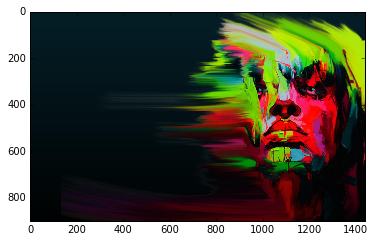

In [14]:
# print len(image[1][0])
# image[0] = np.pad(image[0], pad_width=padding, mode='constant', constant_values=0)
print image
plt.imshow(image.T)

In [15]:
print "image shape = ", image.shape

image shape =  (3, 1440, 900)


In [63]:
#kernel formation

kernel = np.random.rand(3,6,6)
# print "kernel = ", kernel

# CNN

stride = 2
pad = 40
kernels_in_layer = 3
activation_function = 'sin'
no_of_layers = 4

# ANN

hidden_layers = 4
output_size = 5
hidden_layer_vector = np.array([3,3,4,output_size])

In [73]:
kernel_vector = np.array([3,2,3,2])
stride_vector = np.array([1,1,1,1])
padding_vector = np.array([1,1,1,1])
non_linear_vector = np.array(['sin','sin','sin','sin'])
pooling_function_vector = np.array(['sin','sin','sin','sin'])


output_volume_shape =  (3, 1439, 899)
output_volume_shape =  (2, 719, 449)
output_volume_shape =  (3, 359, 225)
output_volume_shape =  (2, 179, 113)


In [ ]:
final_class = final_function(image, no_of_layers, kernel_vector, stride_vector, padding_vector, non_linear_vector, pooling_function_vector, flat_vector, hidden_layers, hidden_layer_vector)

In [95]:
print "final class = ", final_class+1

print
print
print
print "below is given output analysis at each process"
print 
print
print

final class =  2



below is given output analysis at each process





In [22]:
activation_volume = convolution_layer(image, kernels_in_layer, stride, pad, activation_function)



this is the output at one of the kernels

size of activation volume at one of the comvolutional layers =  (3, 758, 488)

this is also padded uniformly




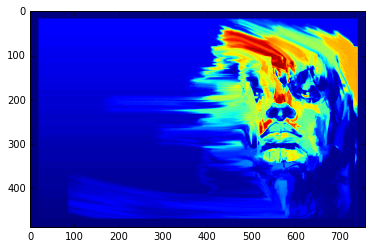

In [88]:
print 
print
print "this is the output at one of the kernels"
print 
print "size of activation volume at one of the comvolutional layers = ", activation_volume.shape
print 
print "this is also padded uniformly"
print 
print 
plt.imshow(activation_volume[0].T)

In [84]:
print pooling_output.shape
plt.imshow(pooling_output.T)

NameError: name 'pooling_output' is not defined

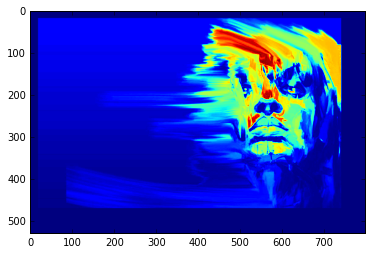

In [89]:
activation_matrix = Convolutional_function(image, kernel, stride, pad, activation_function)
# print "activation matrix = ", activation_matrix
plt.imshow(activation_matrix.T)



this image is after pooling, the image is a bit blurred

(264, 399)


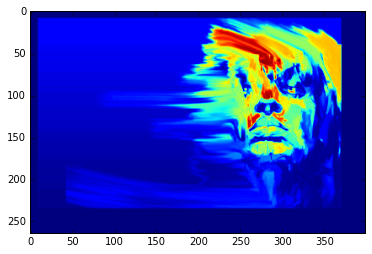

In [98]:

pooled_matrix = pooling(activation_matrix.T, 'max')
print 
print
print"this image is after pooling, the image is a bit blurred"
print
print pooled_matrix.shape
plt.imshow((pooled_matrix))